# Analysis part 2: Analyze the frequency components of the audio signals
The raw audio traces are analyzed here with respect to the frequency components of the signal. Two things are calculated: amplitude spectra from 5 s before to 5 s after each stimulation and Fourier transforms of the signal before, during, and after stimulation. Both, the spectra and the Fourier curves are averaged for stimuli of the same intensity and again over all experiments of the same condition. The spectra are calculted with short-time Fourier transforms (non-overlapping segments of 700 data point length). The Fourier transforms are calculated as real number Fourier transforms omitting the negative frequency range. The results are reduced to frequencies between 0 and 1000 Hz. 
The results will be saved in a pandas pickle file named *freq_analysis_data.pkl*. The analysis will only be performed if there is no file with this name in the current directory otherwise the file will be loaded. 

Author:         Bjarne Schultze <br>
Last modified:  01.12.2023

In [1]:
import numpy as np
import pandas as pd
import h5py
import opto_analysis_fun as oafun
import matplotlib.pyplot as plt
import re

# Use my own plot style
plt.style.use('./plotstyle_bjarne.mplstyle')  
# Define two colors indicating activation and inactivation
act_col = '#DB0D55'
iact_col = '#5B9403'

##### Preparations

In [2]:
# Set the path where the data is stored
dat_path = 'D:/BehaviorData/Research_module_drosophila/'

# Load the file with the experiment names and condition information
experiments = pd.read_csv("experiments_list.txt", delimiter=' ', names=["directory","group","flyline","food"])
# Convert string with food information into python list
for i in range(len(experiments)):
    experiments.at[i,"food"] = experiments.at[i,"food"].strip('][').split(',')

In [3]:
# Try to load the analysis data
try:
    freq_data = pd.read_pickle("./freq_analysis_data.pkl")
    uinput = 'n'
except FileNotFoundError:
    print("The file was not found! You might need to run the analysis again.")
    uinput = input("Do you want to run the analysis again now? [y/n] ")

# Set number of audion channels
n_audio_chan = 3

##### Main analysis loop for all datasets

In [4]:
# Run the main analysis, if requested
if uinput.lower() == "y":
    print("Analysis started ...")

    # Initialize an empty data frame to collect the results
    freq_data = pd.DataFrame()

    # Iterate over all datasets
    for filenum,file in enumerate(experiments["directory"]):
        # Load and assemble the current dataset
        filename = dat_path+file+'/'+file+'_daq.h5'
        data_in = h5py.File(filename)
        print(f'Working on file: {filename}')
        dataset = np.array(data_in['samples'])
        # Get the sampling rate
        sampling_rate = round(np.mean(data_in['samplenumber']))
        # Create a time vector
        time_vec = np.arange(0, dataset.shape[0]/sampling_rate, 1/sampling_rate)

        # Extract the audio data
        audio_data = dataset[:,:n_audio_chan]

        # Analyze the light stimulus to get on- and offsets as well as stimulation voltage values
        light, stim_mode, stim_on, stim_off, stim_volt = oafun.analyze_light_stim(dataset[:,n_audio_chan:])
        stim_volt_u = np.unique(stim_volt)

        # Compute the spectra for all three channels and average over all stimuli of the same intensity (shape: stimuli(unique)*freqs*channels*time_points)
        spec_cont_avg, freqs, time_points = oafun.freqency_analysis(audio_data, sampling_rate, stim_on, stim_off, stim_volt, continuous=True)
        
        # Transform the audio signal to the time domain and average over all stimuli of the same intensity (shape: stimuli(unique)*freqs*channels)
        fft_stim_avg, fft_pre_avg, fft_post_avg, fft_freqs = oafun.freqency_analysis(audio_data, sampling_rate, stim_on, stim_off, stim_volt, continuous=False)

        # Split the data from one dataset into the three channels/chambers and store them as separate entries
        for chan in range(n_audio_chan):
            if experiments.at[filenum,"food"][chan] != 'None':
                current_data = pd.concat([experiments.loc[filenum,:], pd.Series({"food_grp":experiments.at[filenum,"food"][chan],
                                                                                 "spec_freqs":freqs, "spec_time":time_points, "spectogrm":spec_cont_avg[:,:,chan,:], 
                                                                                 "fft_stim":fft_stim_avg[:,:,chan], "fft_pre_stim":fft_pre_avg[:,:,chan], 
                                                                                 "fft_post_stim":fft_post_avg[:,:,chan], "fft_freqs":fft_freqs, 
                                                                                 "stim_mode":stim_mode,"stim_volt":stim_volt,"stim_volt_u":stim_volt_u,"stim_on":stim_on,
                                                                                 "stim_off":stim_off})])
                freq_data = pd.concat([freq_data,current_data], axis=1)     # Append data of current channel to big data frame

    # Format the results to a data frame
    freq_data = freq_data.transpose().reset_index().drop(["food","index"], axis=1)

    # Create a label for each condition
    label = []
    for exp in range(len(freq_data)):
        label.append("_".join([freq_data.at[exp,"flyline"], freq_data.at[exp,"stim_mode"][:3], freq_data.at[exp,"food_grp"][:3]]))
    # Add labels to the data frame
    freq_data = pd.concat([freq_data,pd.Series(label,name="label")], axis=1)

    # Save the analysis data
    out_file = "freq_analysis_data.pkl" 
    pd.to_pickle(freq_data, "./" + out_file)

    # Print finish message
    print(f"Finished analysis! Results saved as {out_file}.")

##### Average the results across datasets (for the same conditions)

In [5]:
# Ensure that all entries in the freq_data data frame have the same frequency values corresponding to the spectrogram values (otherwise averaging would not be meaningful)
test_freqs = freq_data.at[0, 'spec_freqs']
test_time = freq_data.at[0, 'spec_time']
test_fft_freqs = freq_data.at[0, 'fft_freqs']

for i in range(len(freq_data)):
    if (freq_data.at[i, 'spec_freqs'] != test_freqs).any():
        print("Unable to average because of different frequency values (y axis)!")
        break
    if (freq_data.at[i, 'spec_time'] != test_time).any():
        print("Unable to average because of different time values (x axis)!")
        break
    if (freq_data.at[i, 'fft_freqs'] != test_fft_freqs).any():
        print("Unable to average because of different FFT frequency values (x axis)!")
        break
else:
    print("No problems found! Averaging the results across datasets is possible.")

No problems found! Averaging the results across datasets is possible.


In [6]:
# Get the conditions and re-sort them for plotting
resort_idx = [3,2,4,6,0,1,7,9,5,8]
conditions = freq_data['label'].unique()[resort_idx]

# Allocate lists to store the results
m_specs = []
sd_specs = []
m_fft_stim = []
m_fft_pre = []
m_fft_post = []
stims = []

# Iterate through all conditions
for cond in conditions:
    # Find indices of current condition
    cond_idx = freq_data.loc[:,'label'] == cond
    # Extract data for current condition
    cond_spec = np.array(freq_data.loc[cond_idx, 'spectogrm'].tolist())
    cond_fft_stim = np.array(freq_data.loc[cond_idx, 'fft_stim'].tolist())
    cond_fft_pre = np.array(freq_data.loc[cond_idx, 'fft_pre_stim'].tolist())
    cond_fft_post = np.array(freq_data.loc[cond_idx, 'fft_post_stim'].tolist())
    # Extract the corresponding stimulus values
    cond_stims = np.array(freq_data.loc[cond_idx, 'stim_volt_u'].tolist())
    stims_u = np.unique(cond_stims)

    # Create temporary lists to store the averaging results per stimulus
    tmp_m_spec = []
    tmp_sd_spec = []

    tmp_mfft_stim = []
    tmp_mfft_pre = []
    tmp_mfft_post = []

    # Iterate over the stimulus intensities
    for stim in stims_u:
        # Get indices of current stimulus intensity
        irow, icol = np.where(np.array(cond_stims) == stim)
        # Calculate average and standard deviation for the spectrogram
        tmp_m_spec.append(np.mean(cond_spec[irow, icol, :, :], axis=0))
        tmp_sd_spec.append(np.std(cond_spec[irow, icol, :, :], axis=0))

        # Calculate the average of the Fourier transforms
        tmp_mfft_stim.append(np.mean(cond_fft_stim[irow, icol, :], axis=0))
        tmp_mfft_pre.append(np.mean(cond_fft_pre[irow, icol, :], axis=0))
        tmp_mfft_post.append(np.mean(cond_fft_post[irow, icol, :], axis=0))

    # Store the temporary results
    m_specs.append(tmp_m_spec)
    sd_specs.append(tmp_sd_spec)

    m_fft_stim.append(tmp_mfft_stim)
    m_fft_pre.append(tmp_mfft_pre)
    m_fft_post.append(tmp_mfft_post)

    stims.append(stims_u)

### Plot average frequency amplitude spectra for all conditions

Text(2.49, 1296.0, 'Control group')

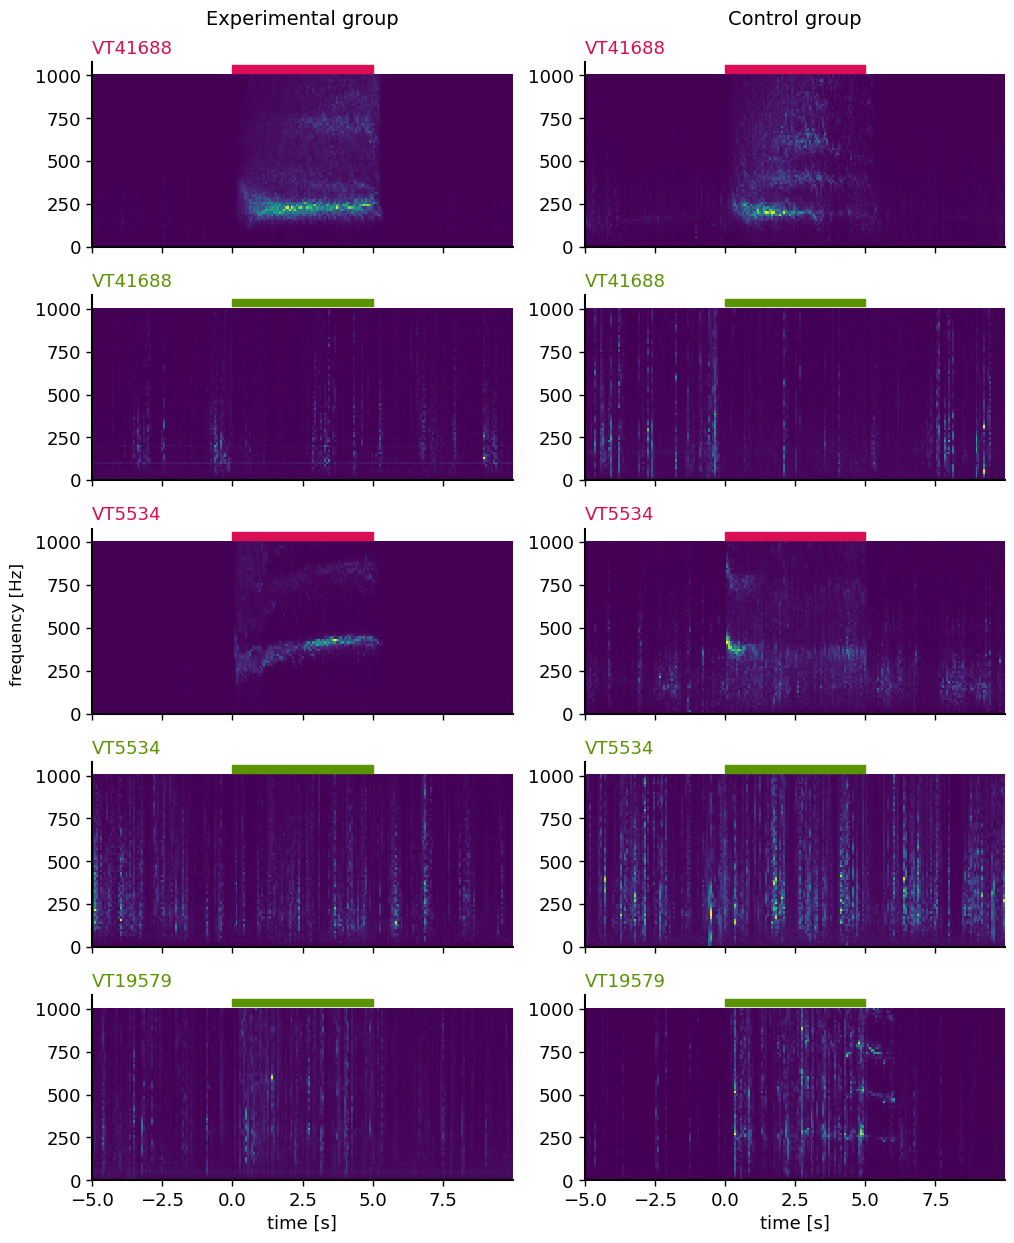

In [7]:
# Select a stimulus intensity (mV)
stim = 1
# Get the sample frequencies and the time vector for the spectrograms (always the same, checked above)
spec_f = freq_data.at[0, 'spec_freqs']
spec_time = freq_data.at[0, 'spec_time'] - 5
# Set a common alpha value
calpha = 0.6

# Set up a new figure
fig, ax = plt.subplots(5, 2, figsize=(10,12), sharex=True)
ax = ax.flatten()

# Iterate over all conditions
for cidx,cond in enumerate(conditions):
    # Find the indices where the given stimulus was applied
    stim_idx = np.where(stims[cidx] == stim)[0][0]

    # Distinguish between activation and inactivation
    if len(re.findall('act', cond)) > 0:
        stim_col = act_col
    elif len(re.findall('ina', cond)) > 0: 
        stim_col = iact_col

    # Plot the spectrogram
    ax[cidx].pcolormesh(spec_time, spec_f, m_specs[cidx][stim_idx])
    # Add bar which indicates the stimulation
    ax[cidx].fill_between([0,5], 1015, 1060, color=stim_col)

    # Add a title
    ax[cidx].set_title(re.findall('VT[0-9]+',cond)[0], loc='left', color=stim_col)
    # Force a tight layout 
    plt.tight_layout()
    ax[cidx].set_ylim([0,1080])

# Add labels
ax[-1].set_xlabel('time [s]')
ax[-2].set_xlabel('time [s]')
fig.supylabel('frequency [Hz]', x=-0.01)

# Add titles per column stating experimental and control group
xcenter = np.mean(ax[0].get_xlim())
ylimits = ax[0].get_ylim()
ax[0].text(xcenter, ylimits[1]*1.2, "Experimental group", size=14, horizontalalignment='center')
ylimits = ax[1].get_ylim()
ax[1].text(xcenter, ylimits[1]*1.2, "Control group", size=14, horizontalalignment='center')

# # Save figure
# fig.savefig('./Report/figures/mean_specs.pdf', bbox_inches='tight')

### Plot average Fourier transforms for all conditions

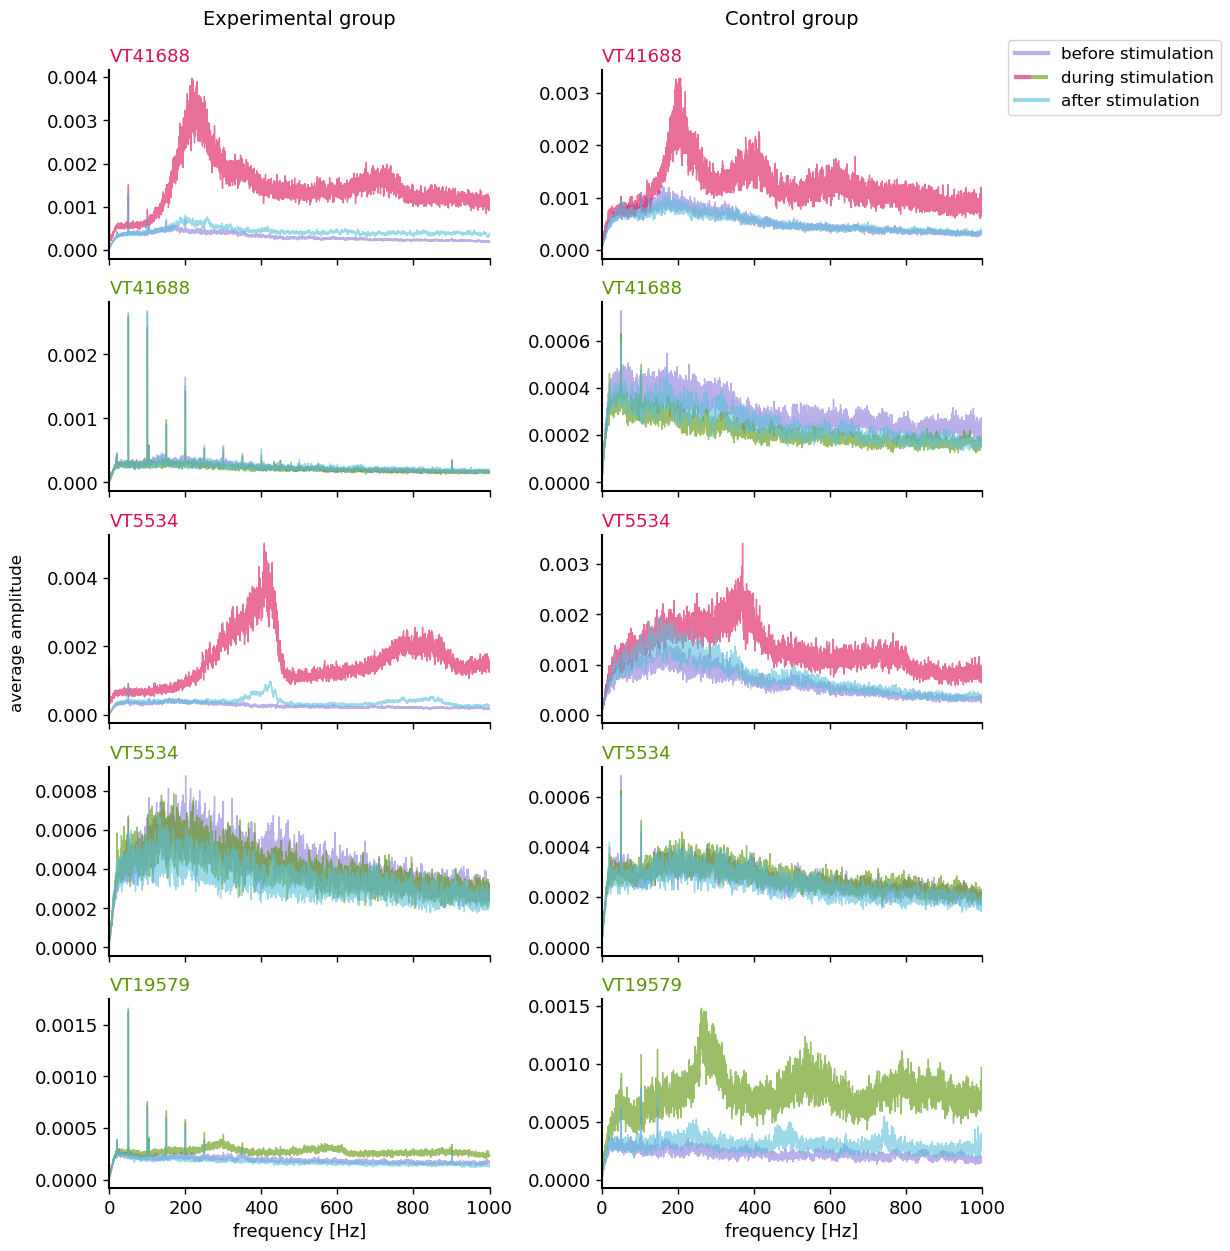

In [10]:
# Select a stimulus intensity (mV)
stim = 1
# Get the sample frequencies for the Fourier transforms (always the same, checked above)
f = freq_data.at[0, 'fft_freqs']
# Set a common alpha value
calpha = 0.6

# Set up a new figure
fig, ax = plt.subplots(5, 2, figsize=(10,12), sharex=True)
ax = ax.flatten()

# Iterate over all conditions
for cidx,cond in enumerate(conditions):
    # Find the indices where the given stimulus was applied
    stim_idx = np.where(stims[cidx] == stim)[0][0]
    # Select the data accordingly
    cond_fft_stim = m_fft_stim[cidx][stim_idx]
    cond_fft_pre = m_fft_pre[cidx][stim_idx]
    cond_fft_post = m_fft_post[cidx][stim_idx]

    # Distinguish between activation and inactivation
    if len(re.findall('act', cond)) > 0:
        stim_col = act_col
    elif len(re.findall('ina', cond)) > 0: 
        stim_col = iact_col

    # Plot the Fourier transforms of the signal before, during, and after stimulation
    lbstim, = ax[cidx].plot(f, cond_fft_pre, label='before stimulation', color='#8B7BDB', alpha=calpha)
    ax[cidx].plot(f, cond_fft_stim, label='during stimulation', color=stim_col, alpha=calpha)
    lastim, = ax[cidx].plot(f, cond_fft_post, label='after stimulation', color='#59C0DB', alpha=calpha)

    # Add a title
    ax[cidx].set_title(re.findall('VT[0-9]+',cond)[0], loc='left', color=stim_col)
    # Force a tight layout 
    ax[cidx].autoscale(axis='x', tight=True)
    plt.tight_layout()

# Add proxy artists to the upper right subplot (needed to create a proper legend)
lact, = ax[1].plot([], [], color=act_col, marker=0, linestyle='none', markersize=12, markeredgewidth=3, alpha=calpha)
liact, = ax[1].plot([], [], color=iact_col, marker=1, linestyle='none', markersize=12, markeredgewidth=3, alpha=calpha)

# Add labels
ax[-1].set_xlabel('frequency [Hz]')
ax[-2].set_xlabel('frequency [Hz]')
fig.supylabel('average amplitude', x=-0.01)
# Add a legend for all artists of all subplots
lgd = ax[1].legend([lbstim,(lact,liact),lastim], ['before stimulation', 'during stimulation', 'after stimulation'], 
                    loc='upper right', bbox_to_anchor=(1.65,1.2))

# Increase the linewidth of the lines in the legend
for legobj in lgd.legend_handles:
    legobj.set_linewidth(3.0)

# Add titles per column stating experimental and control group
xcenter = np.mean(ax[0].get_xlim())
ylimits = ax[0].get_ylim()
ax[0].text(xcenter, ylimits[1]*1.25, "Experimental group", size=14, horizontalalignment='center')
ylimits = ax[1].get_ylim()
ax[1].text(xcenter, ylimits[1]*1.25, "Control group", size=14, horizontalalignment='center')

# Save figure
# fig.savefig('./Report/figures/mean_ffts.pdf', bbox_inches='tight')

# Note: In many conditions there is a peak at 50 Hz as well as its harmonic frequencies. 